In [2]:
#Import Pakcages
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from urllib.request import urlretrieve
import zipfile
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [3]:
#Load Sample Data
urlretrieve("https://raw.githubusercontent.com/prateekjoshi565/textrank_text_summarization/master/tennis_articles_v4.csv", filename="tennis_articles_v4.csv")
data = pd.read_csv("tennis_articles_v4.csv")
data.head(2)

,article_id,article_text,source
0,1,Maria Sharapova has basically no friends as te...,https://www.tennisworldusa.org/tennis/news/Mar...
1,2,"BASEL, Switzerland (AP), Roger Federer advance...",http://www.tennis.com/pro-game/2018/10/copil-s...


In [5]:
# #Use Glove for text Embedding
# urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
# zf = zipfile.ZipFile('glove.6B.zip')
# zf.extractall() 
# zf.close()

In [6]:
glove_dict = dict()
f = open('glove.6B.100d.txt', encoding="utf8") # 100차원의 GloVe 벡터를 사용

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    glove_dict[word] = word_vector_arr
f.close()

In [7]:
#For OOV
embedding_dim = 100
zero_vector = np.zeros(embedding_dim)

In [8]:
def calculate_sentence_vector(sentence):
    return sum([glove_dict.get(word, zero_vector) for word in sentence])/len(sentence)

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kimjoonhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kimjoonhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
data = data[['article_text']]
data['sentences'] = data['article_text'].apply(sent_tokenize)

In [15]:
data.head(1)

,article_text,sentences
0,Maria Sharapova has basically no friends as te...,[Maria Sharapova has basically no friends as t...


In [16]:
def tokenization(sentences):
    return [word_tokenize(sentence) for sentence in sentences]


def preprocess_sentence(sentence):

    sentence = [re.sub(r'[^a-zA-z\s]', '', word).lower() for word in sentence]

    return [word for word in sentence if word not in stop_words and word]


def preprocess_sentences(sentences):
    return [preprocess_sentence(sentence) for sentence in sentences]

In [17]:
data['tokenized_sentences'] = data['sentences'].apply(tokenization)
data['tokenized_sentences'] = data['tokenized_sentences'].apply(preprocess_sentences)

In [18]:
def calculate_sentence_vector(sentence):
    if len(sentence) != 0:
        return sum([glove_dict.get(word, zero_vector) for word in sentence])/len(sentence)
    else:
        return zero_vector

In [19]:
def make_sentences_to_vectors(sentences):
    return [calculate_sentence_vector(sentence) for sentence in sentences]

In [20]:
data['SentenceEmbedding'] = data['tokenized_sentences'].apply(make_sentences_to_vectors);data[['SentenceEmbedding']]

,SentenceEmbedding
0,"[[0.051488996, 0.1105585, 0.6950863, 0.1891917..."
1,"[[0.10566062456928194, -0.10534465219825506, 0..."
2,"[[-0.022272188, -0.0474477, 0.14933074, -0.086..."
3,"[[0.045201838, -0.064647146, 0.5035717, -0.160..."
4,"[[0.21536233, 0.180915, 0.25600883, 0.06924241..."
5,"[[0.04484453, -0.0074302587, 0.33349112, -0.07..."
6,"[[-0.115338005, -0.0062844106, 0.595185, -0.16..."
7,"[[0.0740439, 0.059211146, 0.49143884, 0.216771..."


In [21]:
def make_similarity_matrix(sentence_embedding):
    sim_matrix = np.zeros([len(sentence_embedding), len(sentence_embedding)])
    for x in range(len(sentence_embedding)):
        for y in range(len(sentence_embedding)):
            sim_matrix[x][y] = cosine_similarity(sentence_embedding[x].reshape(1, embedding_dim),sentence_embedding[y].reshape(1, embedding_dim))[0,0]
    return sim_matrix

In [22]:
data['SimMatrix'] = data['SentenceEmbedding'].apply(make_similarity_matrix);data['SimMatrix']

0    [[1.0, 0.6477208733558655, 0.5915699601173401,...
1    [[0.9999999999999998, 0.8745531210608368, 0.80...
2    [[1.0, 0.9130854606628418, 0.8992924690246582,...
3    [[0.9999998211860657, 0.7769179305294042, 0.84...
4    [[1.0, 0.8306209732530097, 0.9082390069961548,...
5    [[1.0, 0.8843014240264893, 0.8540289072721127,...
6    [[1.0, 0.4730549454689026, 0.45002689957618713...
7    [[1.0, 0.7634095600081804, 0.7822568416595459,...
Name: SimMatrix, dtype: object

In [23]:
def draw_graphs(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
    return plt.show()

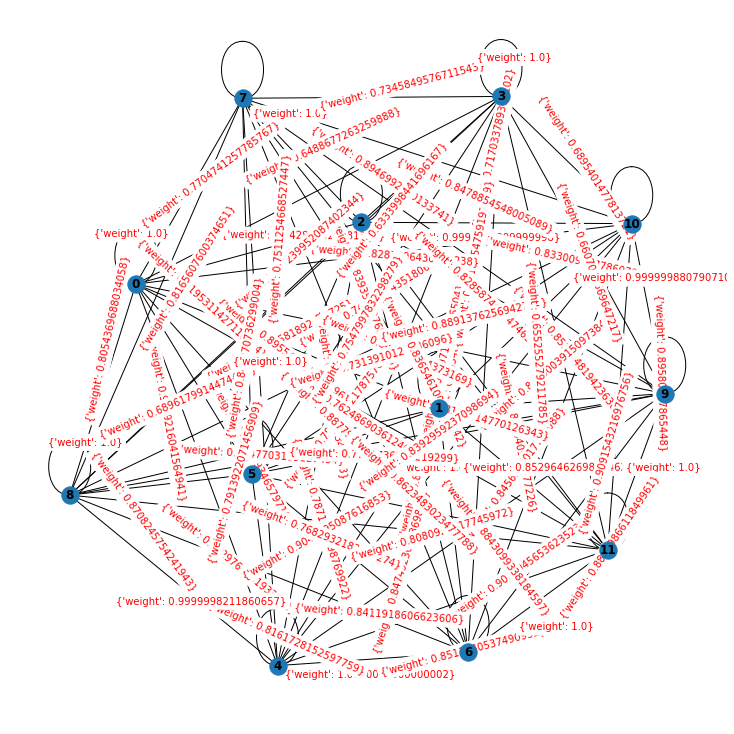

In [24]:
draw_graphs(data['SimMatrix'][1])

In [25]:
def calculate_score(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)
    return scores

In [26]:
data['score'] = data['SimMatrix'].apply(calculate_score)
data[['SimMatrix', 'score']]

,SimMatrix,score
0,"[[1.0, 0.6477208733558655, 0.5915699601173401,...","{0: 0.054921592349971654, 1: 0.062865201583949..."
1,"[[0.9999999999999998, 0.8745531210608368, 0.80...","{0: 0.08315094519830243, 1: 0.0849861145240060..."
2,"[[1.0, 0.9130854606628418, 0.8992924690246582,...","{0: 0.06148440897383897, 1: 0.0622486432622569..."
3,"[[0.9999998211860657, 0.7769179305294042, 0.84...","{0: 0.08164727863031544, 1: 0.0727647951622424..."
4,"[[1.0, 0.8306209732530097, 0.9082390069961548,...","{0: 0.055686899302859666, 1: 0.050992318459540..."
5,"[[1.0, 0.8843014240264893, 0.8540289072721127,...","{0: 0.08288694384753871, 1: 0.0840376011107923..."
6,"[[1.0, 0.4730549454689026, 0.45002689957618713...","{0: 0.07336251724543942, 1: 0.1050889010191760..."
7,"[[1.0, 0.7634095600081804, 0.7822568416595459,...","{0: 0.04321039298875788, 1: 0.0473333989320208..."


In [49]:
data["sentences"][0]

['Maria Sharapova has basically no friends as tennis players on the WTA Tour.',
 "The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much.",
 'I think everyone knows this is my job here.',
 "When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match.",
 "I'm a pretty competitive girl.",
 "I say my hellos, but I'm not sending any players flowers as well.",
 "Uhm, I'm not really friendly or close to many players.",
 "I have not a lot of friends away from the courts.'",
 'When she said she is not really close to a lot of players, is that something strategic that she is doing?',
 "Is it different on the men's tour than the women's tour?",
 "'No, not at all.

In [56]:
data["score"][0]

{0: 0.054921592349971654,
 1: 0.06286520158394943,
 2: 0.0610969992312916,
 3: 0.06454730711703867,
 4: 0.058010540473227214,
 5: 0.06095180767361698,
 6: 0.06353301749138765,
 7: 0.06300423304416121,
 8: 0.0644012226300051,
 9: 0.058102711764646625,
 10: 0.009287941176470589,
 11: 0.06529652589563242,
 12: 0.06283888776578792,
 13: 0.06259499538094113,
 14: 0.0644486804622281,
 15: 0.06165576413655774,
 16: 0.06244257182308592}

In [63]:
def rank_sentences(sentences, scores):
    top_scores = sorted(((scores[idx],sent) for idx,sent in enumerate(sentences)), reverse=True)
    top_sentences = [sentence for score,sentence in top_scores]
    return top_sentences

In [64]:
data['summary'] = data.apply(lambda x: rank_sentences(x.sentences, x.score), axis=1)

In [65]:
data['summary'][0]

["I think just because you're in the same sport doesn't mean that you have to be friends with everyone just because you're categorized, you're a tennis player, so you're going to get along with tennis players.",
 "When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match.",
 "I think everyone just thinks because we're tennis players we should be the greatest of friends.",
 'When she said she is not really close to a lot of players, is that something strategic that she is doing?',
 "Uhm, I'm not really friendly or close to many players.",
 "I have not a lot of friends away from the courts.'",
 "The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much.",
